# Coding Assignment - Word2vec

- Try a real corpus (instead of banana apple, try something real... on the internet....) - not so big!  Just so you have a good taste of real stuff....like 50 documents, each having 50 words...(really up to you)

- Try a window size of 2

- Implement CBOW (instead of skipgrams)

- Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

In [171]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import pandas as pd

## 1. Try a real corpus - Load Data
Dataset import from NLTK library 

In [172]:
import nltk 
from nltk.corpus import brown, inaugural
nltk.download('punkt')
nltk.download('brown')
nltk.download('inaugural')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [173]:
corpus = inaugural.sents('1789-Washington.txt') 

In [174]:
#1. tokenize reference
# import spacy
# nlp = spacy.load("en_core_web_sm")
# tokenize = nlp("I eat apple.")

# for i in tokenize:
#     print(i.text)

In [175]:
corpus

[['Fellow', '-', 'Citizens', 'of', 'the', 'Senate', 'and', 'of', 'the', 'House', 'of', 'Representatives', ':'], ['Among', 'the', 'vicissitudes', 'incident', 'to', 'life', 'no', 'event', 'could', 'have', 'filled', 'me', 'with', 'greater', 'anxieties', 'than', 'that', 'of', 'which', 'the', 'notification', 'was', 'transmitted', 'by', 'your', 'order', ',', 'and', 'received', 'on', 'the', '14th', 'day', 'of', 'the', 'present', 'month', '.'], ...]

In [176]:
#2. numericalize #assign id to all this vocabs #add <UNK> word 
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus)))
word2index = {v: idx for idx, v in enumerate(vocabs)}
vocabs.append('<UNK>')

In [177]:
#3. create index2word dictionary   
index2word = {v:k for k, v in word2index.items()}

index2word

{0: 'out',
 1: 'perfect',
 2: 'but',
 3: 'regard',
 4: 'attention',
 5: 'dear',
 6: 'fortified',
 7: 'expected',
 8: 'carefully',
 9: 'conducts',
 10: 'addition',
 11: 'equal',
 12: 'summons',
 13: 'foundation',
 14: 'judgment',
 15: 'allotted',
 16: 'swayed',
 17: '14th',
 18: 'pursuit',
 19: 'no',
 20: 'form',
 21: 'unanimity',
 22: 'be',
 23: 'possible',
 24: 'interruptions',
 25: 'affected',
 26: 'thinking',
 27: 'experienced',
 28: 'Having',
 29: 'conscious',
 30: 'system',
 31: 'well',
 32: 'judged',
 33: 'distrustful',
 34: 'views',
 35: 'power',
 36: 'happiness',
 37: 'rules',
 38: 'official',
 39: 'care',
 40: 'enable',
 41: 'seem',
 42: 'foregoing',
 43: 'revolution',
 44: 'tranquillity',
 45: '."',
 46: 'attributes',
 47: '.',
 48: 'You',
 49: 'inapplicable',
 50: 'Besides',
 51: 'opportunities',
 52: 'struggle',
 53: 'never',
 54: 'ought',
 55: 'urged',
 56: 'Such',
 57: 'The',
 58: 'voice',
 59: 'made',
 60: 'rights',
 61: 'blessing',
 62: 'have',
 63: 'circumstance',
 64:

In [179]:
vocabs

['out',
 'perfect',
 'but',
 'regard',
 'attention',
 'dear',
 'fortified',
 'expected',
 'carefully',
 'conducts',
 'addition',
 'equal',
 'summons',
 'foundation',
 'judgment',
 'allotted',
 'swayed',
 '14th',
 'pursuit',
 'no',
 'form',
 'unanimity',
 'be',
 'possible',
 'interruptions',
 'affected',
 'thinking',
 'experienced',
 'Having',
 'conscious',
 'system',
 'well',
 'judged',
 'distrustful',
 'views',
 'power',
 'happiness',
 'rules',
 'official',
 'care',
 'enable',
 'seem',
 'foregoing',
 'revolution',
 'tranquillity',
 '."',
 'attributes',
 '.',
 'You',
 'inapplicable',
 'Besides',
 'opportunities',
 'struggle',
 'never',
 'ought',
 'urged',
 'Such',
 'The',
 'voice',
 'made',
 'rights',
 'blessing',
 'have',
 'circumstance',
 'finally',
 'unparalleled',
 'waste',
 'he',
 'lights',
 'all',
 'deliberations',
 'itself',
 'little',
 'should',
 'share',
 'place',
 'national',
 'avoid',
 'laid',
 'United',
 'Heaven',
 'nature',
 'trust',
 'expresses',
 'supply',
 'any',
 'dist

## 2. prepare to train data
skipgrams and cbows

In [180]:
#move along the corpus
#to fit with our corpus, we gonna use window_size = 2

skipgrams = []
cbows = []
#for each corpus
for sent in corpus:
  
    for i in range(2, len(sent) - 2): #start from 1 to second last
        center_word = sent[i]
        outside_word = [sent[i-2],sent[i-1],sent[i+1],sent[i+2]] #window_size = 2
        for o in outside_word:
            skipgrams.append([center_word, o])
        cbows.append([center_word, outside_word])

corpus[0]        

['Fellow',
 '-',
 'Citizens',
 'of',
 'the',
 'Senate',
 'and',
 'of',
 'the',
 'House',
 'of',
 'Representatives',
 ':']

In [181]:
#let's make what we have made into a function (batch function)
def random_batch(batch_size, corpus):
    
    skipgrams = []
    cbows = []
    #for each corpus
    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+2]]]  #window_size = 2
            for o in outside_words:
                skipgrams.append([center_word, o])
            cbows.append([center_word, outside_word])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][1]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][0]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [182]:
input, label = random_batch(10, corpus)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[546],
       [433],
       [156],
       [ 95],
       [175],
       [353],
       [225],
       [434],
       [610],
       [ 77]])


## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

### cbows

In [185]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_w - vectors of all vocabs

class cbows(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(cbows, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [186]:
#preparing all_vocabs

bbatch_size = 2 #why? no reason
emb_size = 2 #usually, this can be 50, 100, or 300
model = cbows(voc_size, emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [187]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 630])

In [188]:
torch.LongTensor(2)
torch.LongTensor([2])  #put shape (, 1)


tensor([2])

## 4. Training

In [189]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 6.610834 | Time: ??
Epoch 2000 | Loss: 10.286052 | Time: ??
Epoch 3000 | Loss: 4.083121 | Time: ??
Epoch 4000 | Loss: 6.074234 | Time: ??
Epoch 5000 | Loss: 9.114964 | Time: ??


## 5. Plot the embeddings

In [190]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

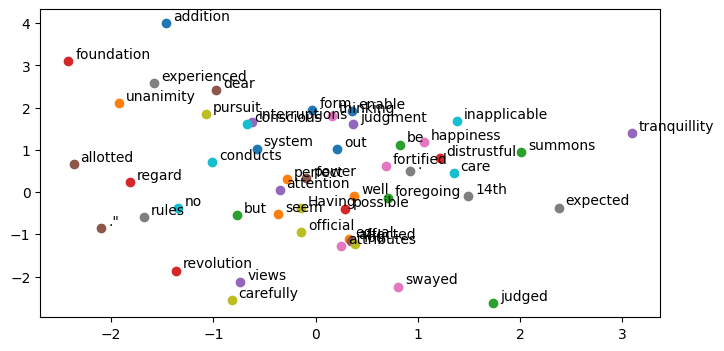

In [191]:
#matplotlib
plt.figure(figsize=(8,4))
for i, word in enumerate(vocabs[:50]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

#### Normal version of skipgrams
- Model


In [192]:
class Skipgram(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

In [193]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 630])

- Training

In [194]:
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [195]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 6.499329 | Time: ??
Epoch 2000 | Loss: 7.764049 | Time: ??
Epoch 3000 | Loss: 6.041340 | Time: ??
Epoch 4000 | Loss: 7.419616 | Time: ??
Epoch 5000 | Loss: 7.465458 | Time: ??


- Plot the embeddings

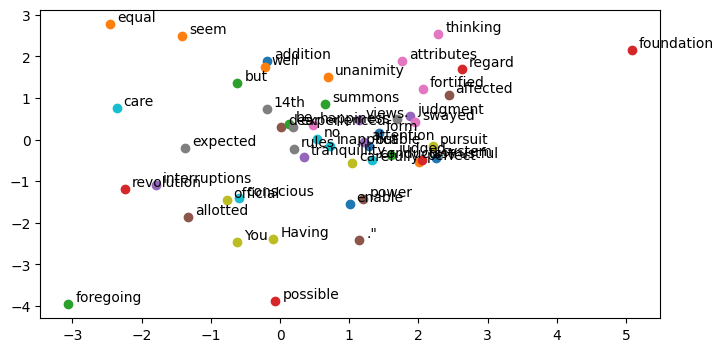

In [210]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()
#matplotlib
plt.figure(figsize=(8,4))
for i, word in enumerate(vocabs[:50]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

- Negative sampling version of skipgrams

In [197]:
z = 0.001  #scaling up low frequency terms
#count all the occurrences of vocabs
from collections import Counter

word_count = Counter(flatten(corpus))
word_count

Counter({'Fellow': 1,
         '-': 1,
         'Citizens': 1,
         'of': 71,
         'the': 115,
         'Senate': 1,
         'and': 48,
         'House': 2,
         'Representatives': 2,
         ':': 1,
         'Among': 1,
         'vicissitudes': 1,
         'incident': 1,
         'to': 47,
         'life': 1,
         'no': 7,
         'event': 2,
         'could': 3,
         'have': 12,
         'filled': 1,
         'me': 8,
         'with': 17,
         'greater': 1,
         'anxieties': 1,
         'than': 6,
         'that': 18,
         'which': 36,
         'notification': 1,
         'was': 4,
         'transmitted': 1,
         'by': 19,
         'your': 9,
         'order': 2,
         ',': 70,
         'received': 1,
         'on': 13,
         '14th': 1,
         'day': 2,
         'present': 5,
         'month': 1,
         '.': 22,
         'On': 2,
         'one': 4,
         'hand': 2,
         'I': 23,
         'summoned': 1,
         'my': 22,
       

In [198]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

1538

In [199]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
Counter(unigram_table)

Counter({'out': 4,
         'perfect': 4,
         'but': 9,
         'regard': 4,
         'attention': 4,
         'dear': 4,
         'fortified': 4,
         'expected': 4,
         'carefully': 4,
         'conducts': 4,
         'addition': 4,
         'equal': 4,
         'summons': 4,
         'foundation': 4,
         'judgment': 4,
         'allotted': 4,
         'swayed': 4,
         '14th': 4,
         'pursuit': 4,
         'no': 17,
         'form': 4,
         'unanimity': 4,
         'be': 42,
         'possible': 4,
         'interruptions': 4,
         'affected': 4,
         'thinking': 4,
         'experienced': 4,
         'Having': 4,
         'conscious': 4,
         'system': 6,
         'well': 6,
         'judged': 4,
         'distrustful': 4,
         'views': 6,
         'power': 4,
         'happiness': 9,
         'rules': 6,
         'official': 6,
         'care': 4,
         'enable': 4,
         'seem': 4,
         'foregoing': 4,
         'revolutio

In [200]:
word_count

Counter({'Fellow': 1,
         '-': 1,
         'Citizens': 1,
         'of': 71,
         'the': 115,
         'Senate': 1,
         'and': 48,
         'House': 2,
         'Representatives': 2,
         ':': 1,
         'Among': 1,
         'vicissitudes': 1,
         'incident': 1,
         'to': 47,
         'life': 1,
         'no': 7,
         'event': 2,
         'could': 3,
         'have': 12,
         'filled': 1,
         'me': 8,
         'with': 17,
         'greater': 1,
         'anxieties': 1,
         'than': 6,
         'that': 18,
         'which': 36,
         'notification': 1,
         'was': 4,
         'transmitted': 1,
         'by': 19,
         'your': 9,
         'order': 2,
         ',': 70,
         'received': 1,
         'on': 13,
         '14th': 1,
         'day': 2,
         'present': 5,
         'month': 1,
         '.': 22,
         'On': 2,
         'one': 4,
         'hand': 2,
         'I': 23,
         'summoned': 1,
         'my': 22,
       

In [201]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

- Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [202]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()


- Training

In [203]:
voc_size   = len(vocabs)
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [204]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 0.709004 | Time: ??
Epoch 2000 | Loss: 0.930477 | Time: ??
Epoch 3000 | Loss: 2.405018 | Time: ??
Epoch 4000 | Loss: 2.215219 | Time: ??
Epoch 5000 | Loss: 1.194782 | Time: ??


- Plot the embeddings

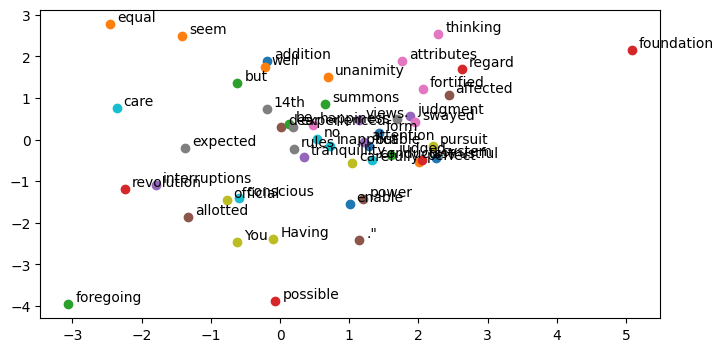

In [209]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()
#matplotlib
plt.figure(figsize=(8,4))
for i, word in enumerate(vocabs[:50]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()